# Оценка модели и уточнения



<h2>Table of Contents</h2>
<ul>
<li> <a href="#ref1"> оценка модели </a> </li>
    <li> <a href="#ref2"> переобучение, недооценка и выбор модели </a> </li>
    <li> <a href="#ref3"> регрессии гребня </a> </li>
    <li> <a href="#ref4"> Поиск по сетке (Grid search) </a> </li>
</ul>


In [301]:
#! mamba install pandas==1.3.3 -y
#! mamba install numpy=1.21.2 -y
#! mamba install sklearn=0.20.1 -y
#! mamba install   ipywidgets=7.4.2 -y

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# загружаем анализируемый csv
path = 'C:/Users/admin/Desktop/python repo/DataAnalysis/Labs/clean_df.csv'
df = pd.read_csv(path)

Во -первых, давайте используем только числовые данные:


In [303]:
# получаем для анализа только числовые столбцы
df = df._get_numeric_data()
#  проверяем
df.head()

,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,...,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,...,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0
1,1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,...,9.0,111,5000.0,16500.0,11.190476,8.703704,0,1,1,0
2,2,1,122,94.5,0.822681,0.909722,0.876254,2823,152,2.68,...,9.0,154,5000.0,16500.0,12.368421,9.038462,0,1,1,0
3,3,2,164,99.8,0.848630,0.919444,0.908027,2337,109,3.19,...,10.0,102,5500.0,13950.0,9.791667,7.833333,0,1,1,0
4,4,2,164,99.4,0.848630,0.922222,0.908027,2824,136,3.19,...,8.0,115,5500.0,17450.0,13.055556,10.681818,0,1,1,0


In [304]:
# при прогрузке ссв иногда появляются лишние столбцы unnamed их нужно удалять
df.drop("Unnamed: 0", axis = 1, inplace=True)
df.head(2)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0
1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,16500.0,11.190476,8.703704,0,1,1,0


Библиотеки для графиков:


In [305]:
from ipywidgets import interact, interactive, fixed, interact_manual

<h2> функции для построения </h2>
Этот код определяет функцию с именем DistributionPlot, которая принимает две функции (RedFunction и BlueFunction), два названия (RedName и BlueName) и заголовок (Title). Он создает фигуру с заданной шириной и высотой, строит распределения двух функций с помощью функции distplot из библиотеки seaborn, устанавливает заголовок и подписи для графика, а затем отображает и закрывает фигуру.
В целом, можно не вставлять никаких функция а писать код каждый раз новый, это не принципиально, но запуская функцию можно добавить ввод в x и у лэйблы с консоли

In [306]:
# Определение функции DistributionPlot с входными параметрами: RedFunction, BlueFunction, RedName, BlueName и Title
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    # примем наименования осей с консоли
    label_x_distplot = input('Введите название оси х графика распределения: ')
    label_y_distplot = input('Введите название оси y графика распределения: ')
    
    width = 12
    height = 10
    # Задание ширины и высоты фигуры
    
    plt.figure(figsize=(width, height))
    # Создание новой фигуры с указанной шириной и высотой
    
    # Построение распределения RedFunction и BlueFunction с помощью функции distplot из библиотеки seaborn
    # Установка цвета графика RedFunction на красный, а BlueFunction на синий
    # Присвоение объектов осей графиков переменным ax1 и ax2 соответственно
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    
    # Установка заголовка графика
    plt.title(Title)
    
    # Установка подписей для осей x и y
    plt.xlabel(label_x_distplot)
    plt.ylabel(label_y_distplot)
     # Отображение графика и закрытие фигуры
    plt.show()
    plt.close()
   

In [307]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr, poly_transform):
    # Устанавливаем размер графика
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    # примем с консоли наименование оси Y
    label_y_polyplot = input('Введите название оси y графика распределения: ')
    
    # Находим максимальное и минимальное значения x для построения графика
    xmax = max([xtrain.values.max(), xtest.values.max()])
    xmin = min([xtrain.values.min(), xtest.values.min()])

    # Создаем массив значений x с шагом 0.1 в диапазоне от xmin до xmax
    x = np.arange(xmin, xmax, 0.1)

    # Рисуем точки обучающего набора данных (красные точки)
    plt.plot(xtrain, y_train, 'ro', label='Training Data')

    # Рисуем точки тестового набора данных (зеленые точки)
    plt.plot(xtest, y_test, 'go', label='Test Data')

    # Предсказываем значения y для значений x с помощью модели lr и полиномиального преобразования poly_transform
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')

    # Устанавливаем пределы по оси y
    plt.ylim([-10000, 60000])

    # Устанавливаем подпись для оси y
    plt.ylabel(label_y_polyplot)

    # Добавляем легенду
    plt.legend()

<h2 id = "ref1"> Часть 1: Обучение и тестирование </h2>

<p> Важным шагом в тестировании вашей модели является разделение ваших данных на данные обучения и тестирования.Мы поместим целевые данные <b> Цена </b> в отдельный DataFrame <b> y_data </b>: </p>


In [308]:
y_data = df['price']

положим все незапвисимые переменные в DataFrame **x_data**, то есть просто удалим цену(зависимую переменную с датасета и присвоим его x_data):


In [309]:
x_data=df.drop('price',axis=1)

Теперь мы случайным образом разделяем наши данные на данные обучения и тестирования, используя функцию <b> train_test_split </b>.



In [310]:
#импортируем функицю train_test_split из модуля model_selection библиотеки sklearn
from sklearn.model_selection import train_test_split

# разделяем x_data на x_train, x_test и y_data на y_train, y_test с помощью этой функции, в пропорции 10 на тестирование и на 90 тренировку
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=None, shuffle = True)

# возвращает количество строк (примеров) в массиве x_test, которое представляет количество тестовых примеров. 
print("number of test samples :", x_test.shape[0])
# возвращает количество строк (примеров) в массиве x_train, которое представляет количество тренировочных примеров.
print("number of training samples:",x_train.shape[0])
# Примечание: логично что тестовых образцов по х и по у одинаково, поэтому нет смысла выводить данные по двум осям


number of test samples : 20
number of training samples: 179


Параметр <b> test_size </b> устанавливает долю данных, которые разделены на набор тестирования.В вышеперечисленном набор тестирования составляет 10% от общего набора данных. 


**НАПРИМЕР:**

Если у вас есть 100 строк наблюдений и вы используете функцию train_test_split с параметром test_size=0.10, то переменная x_train будет содержать 90% (то есть 90 строк) из датафрейма x_data, а переменная x_test будет содержать оставшиеся 10% (то есть 10 строк).

Таким образом, в переменной x_train будет храниться 90 строк из датафрейма x_data. Переменные y_train и y_test будут содержать соответствующие целевые значения для этих строк.

Функция train_test_split используется для разделения данных на обучающую и тестовую выборки. 
Параметр test_size указывает, какую долю данных вы хотите выделить для тестовой выборки. В данном случае, с параметром test_size=0.10, 10% данных будут использоваться для тестирования, а оставшиеся 90% будут использоваться для обучения модели.
В ходе экспериментов было выяснено что в функцию train_test_split включается shuffle = True по умолчанию, которая перемешивает строкиБ если установить False - то тренировочный сет получит последние 10 строц строк датасета так как деление 90 на 10)

Если вы замените x_train1.shape[0] на x_train1.shape[1], то будет выведено количество признаков (столбцов) в обучающей выборке, а не количество образцов (строк). 

Если вы использовать параметр random_state = 1 при разделении данных на обучающую и тестовую выборки, то разделение будет происходить с использованием одного и того же случайного состояния. 

Это означает, что при каждом запуске кода с random_state=1 вы будете получать одно и то же разделение данных на обучающую и тестовую выборки, аналогично и с другими числами, но перемешивание будет по другому алгоритму.

**То есть. выборка с random state = 1 будет рандомная но каждый раз одинаковая, в то время как выброка random state =2 будет всегда идентична, но отлична от выборки 1**

Например, если вы используете функцию train_test_split с параметром test_size=0.2 и random_state=1, то каждый раз, когда вы запускаете код, 80% данных будут использоваться для обучения модели, а 20% данных будут использоваться для тестирования модели, и это разделение будет одинаковым при каждом запуске.

Таким образом, использование random_state = целому числу (например 1) обеспечивает воспроизводимость разделения данных на обучающую и тестовую выборки при каждом запуске кода. Это может быть полезно, если вам нужно получить одинаковое разделение данных для сравнения моделей или повторяемости результатов. 

Если вам не требуется воспроизводимость результатов и вам просто нужно случайное разделение данных, вы можете установить random_state на любое целое число или оставить его без изменений (по умолчанию random_state=None). Это приведет к каждый раз случайному разделению данных.

In [ ]:
# посмотрим инфу про эту функцию
help(train_test_split)

В этом примере мы генерируем 5 разных разделений данных, используя разные значения random_state от 0 до 4. Это позволяет вам оценить стабильность модели на разных разделениях данных.

В целом, выбор оптимального значения random_state зависит от вашей конкретной задачи и требований. Рекомендуется провести несколько экспериментов с разными значениями random_state и выбрать то, которое дает наилучшие результаты для вашей модели.

In [314]:
#  в тестовую выборку попали следующие строки
x_test.head(20)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
11,0,188,101.2,0.849592,0.900000,0.908027,2710,164,3.31,3.19,9.0,121,4250.0,11.190476,8.392857,0,1,1,0
144,1,87,95.7,0.762614,0.883333,0.911371,1985,92,3.05,3.03,9.0,62,4800.0,6.714286,6.025641,0,1,1,0
34,0,110,96.5,0.785199,0.888889,0.911371,2010,92,2.91,3.41,9.2,76,6000.0,7.833333,6.911765,0,1,1,0
197,-1,95,109.1,0.907256,0.956944,0.928094,3217,145,3.01,3.40,23.0,106,4800.0,9.038462,8.703704,1,0,0,1
1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,11.190476,8.703704,0,1,1,0
69,3,142,96.6,0.866410,0.979167,0.849498,3685,234,3.46,3.10,8.3,155,4750.0,14.687500,13.055556,0,1,1,0
155,0,91,95.7,0.799135,0.894444,0.882943,2122,98,3.19,3.03,9.0,70,4800.0,8.392857,6.911765,0,1,1,0
130,3,150,99.1,0.896684,0.923611,0.938127,2808,121,3.54,3.07,9.0,160,5500.0,12.368421,9.038462,0,1,0,1
48,1,104,93.1,0.764536,0.891667,0.904682,1900,91,3.03,3.15,9.0,68,5000.0,7.580645,6.184211,0,1,1,0
184,3,256,94.5,0.796252,0.888889,0.859532,2221,109,3.19,3.40,8.5,90,5500.0,9.791667,8.103448,0,1,1,0


## Давайте импортируем <b> linearregression </b> из модуля <b> linear_model </b>.


In [344]:
from sklearn.linear_model import LinearRegression

Мы создаем объект линейной регрессии:


In [345]:
lre=LinearRegression()

Мы подгоняем  модель, используя функцию «Мощность лошадиных сил»:


In [346]:
# обучаем на столбце и тренировочных данных
lre.fit(x_train[['horsepower']], y_train)

LinearRegression()

Давайте рассчитаем r^2 на тестовых данных:


In [318]:
# к объекту линейной регрессии lre применим функцию score(x,y) и положим в качестве аргументов из 
# фрейма данных для тестирования возьмем столбец "horsepower", в качестве х-параметра и y-параметр из датафрейма y_test
lre.score(x_test[['horsepower']], y_test)

0.5982662649906367

In [319]:
# расчитаем R^2 для фрейма тренировочных данных используя те же параметры
lre.score(x_train[['horsepower']], y_train)

0.6719546222217555

Мы видим, что r^2 намного меньше, при использовании тестовых данных, чем при использовании тренировочных, напомню себе что R^2 должен приближаться к 1 для идеального соответствия
0.65 обозначает что только 65 процентов дисперсии объясняется моделью

<b>
Найдите R^2 в тестовых данных, используя 40% набора данных для тестирования.
</b>
</div>


In [320]:
# разделяем x_data на x_train, x_test и y_data на y_train, y_test с помощью этой функции, в пропорции 40 на тестирование и на 60 тренировку
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
# возвращает количество строк (примеров, наблюдений) в массиве x_test1, которое представляет количество тестовых примеров. 
print("number of test samples X and Y (rows):", x_test1.shape[0])
# возвращает количество строк (примеров, наблюдений) в массиве x_train1, которое представляет количество тренировочных примеров.
print("number of training samples X and Y (rows):",x_train1.shape[0])
# Примечание. Это я делала ранее
#  подгоняем модель
lre.fit(x_train1[['horsepower']],y_train1)
# снова считаем R^2 
lre.score(x_test1[['horsepower']],y_test1)


number of test samples X and Y (rows): 80
number of training samples X and Y (rows): 119


0.7057658850189669

Иногда у вас нет достаточных данных тестирования;

В результате вы можете выполнить перекрестную проверку.

Давайте рассмотрим несколько методов, которые вы можете использовать для перекрестной проверки.

<h2>Оценка перекрестной проверки</h2>


Давайте импортируем <b> model_selection </b> из модуля <b> cross_val_score </b>.


In [321]:
from sklearn.model_selection import cross_val_score

Rcross - Это переменная, в которую сохраняются значения оценок (score) модели для каждого фолда. Каждое значение в Rcross представляет собой оценку модели на соответствующем фолде.

cross_val_score - Эта функция из модуля sklearn.model_selection используется для выполнения кросс-валидации модели. Она принимает модель (lre), признаки (x_data[['horsepower']]), целевую переменную (y_data) и параметр cv=4, который указывает на использование 4-х фолдов ***(каждый фолд это 100 проц данных/на количество фолдов).***

Фолды в кросс-валидации представляют собой разделение обучающего набора данных на равные части. Каждый фолд используется в качестве тестового набора данных, а остальные фолды объединяются в обучающий набор данных. Процесс повторяется для каждого фолда, чтобы каждый фолд был использован в качестве тестового набора данных.

Количество фолдов влияет на кросс-валидацию следующим образом:

1. Большее количество фолдов (например, 10) обеспечивает более точную оценку производительности модели, так как каждый фолд будет использоваться в качестве тестового набора данных, и модель будет оцениваться на разных наборах данных. Однако это требует большего времени для выполнения, так как модель должна быть обучена и оценена для каждого фолда.

2. Меньшее количество фолдов (например, 3) может быть полезно, если у вас ограниченное количество данных или если обучение модели требует значительного времени. Однако оценка производительности модели может быть менее точной, так как модель будет оцениваться только на нескольких наборах данных.

Обычно рекомендуется использовать 5 или 10 фолдов для кросс-валидации, чтобы достичь баланса между точностью оценки и временем выполнения. Однако это может варьироваться в зависимости от конкретной задачи и доступных данных.

**К примеру:**

 если у вас есть датасет с 100 наблюдениями и вы используете параметр cv=4, то ваш датасет будет разделен на 4 фолда. Каждый фолд будет содержать 25 наблюдений. 
Кросс валидация, это итерационный процесс

- В первой итерации кросс-валидации первый фолд будет использоваться в качестве тестового набора данных, **а остальные три фолда объединятся в обучающий набор данных.** 
- Затем модель будет обучаться на обучающем наборе и оцениваться на тестовом наборе. 
- Этот процесс повторяется для каждого фолда, чтобы каждый фолд был использован в качестве тестового набора данных.

Таким образом, в результате кросс-валидации вы получите 4 оценки производительности модели, которые можно усреднить для получения общей оценки.

In [322]:
# выполняем кросс-валидацию модели линейной регрессии на признаке horsepower и целевой переменной y_data 
# с использованием 4-х фолдов, и сохраняет оценки модели для каждого фолда в переменную Rcross.
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

По умолчанию объект кросс валидации вернет оценку r^2.
Каждый элемент в массиве имеет среднее значение r^2 для одного фолда данных:


In [323]:
Rcross

array([0.77344651, 0.53291315, 0.72007907, 0.04475435])

Мы можем рассчитать среднее и стандартное отклонение нашей оценки:


In [324]:
#  применим к объекту кросс валидации функции mean() и std()
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.5177982696090335 and the standard deviation is 0.28734672370921965


Мы можем использовать отрицательную квадратичную ошибку в качестве оценки, установив параметр «оценка» метрики для 'neg_mean_squared_error'.
1. cross_val_score(lre, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error') - это вызов функции cross_val_score, которая выполняет кросс-валидацию модели. 

Она принимает модель lre, признаки x_data[['horsepower']], целевую переменную y_data и параметр cv=4, указывающий на использование 4-х фолдов. 

Параметр scoring='neg_mean_squared_error' указывает на использование среднеквадратичной ошибки (MSE) в качестве метрики оценки модели.

2. -1 * ... - это умножение результата cross_val_score на -1. Это делается для того, чтобы преобразовать метрику оценки (среднеквадратичная ошибка) в отрицательное значение. 

В некоторых случаях, когда функция cross_val_score использует метрику оценки, чем выше значение метрики, тем лучше модель. 

Однако, в данном случае, мы хотим минимизировать среднеквадратичную ошибку, поэтому умножаем на -1, чтобы получить положительное значение ошибки.


In [325]:
Folds_MSE = -1 * cross_val_score(lre, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')
print('MSE для всех фолдов', Folds_MSE)

# Выведем минимальную MSE - лучший параметр
print(f'Минимальная MSE = ', min(Folds_MSE))

# Выведем MSE для каждого фолда
for fold_num, Folds_MSE in enumerate(Folds_MSE):
    print("Fold", fold_num + 1, "error:", Folds_MSE)


MSE для всех фолдов [20533117.27752145 42791870.87475634 13888093.22978046 17774689.32906011]
Минимальная MSE =  13888093.229780464
Fold 1 error: 20533117.277521454
Fold 2 error: 42791870.87475634
Fold 3 error: 13888093.229780464
Fold 4 error: 17774689.32906011


мы получим массив оценок среднеквадратичной ошибки для каждого фолда в кросс-валидации, преобразованных в положительные значения. Это позволяет нам оценить производительность модели и сравнить ее с другими моделями или параметрами.
Каждое число в массиве представляет собой оценку среднеквадратичной ошибки для соответствующего фолда в кросс-валидации.

Чтобы проинтерпретировать эти значения, нужно помнить, что **среднеквадратичная ошибка измеряет разницу между фактическими значениями и предсказанными значениями модели. Чем меньше значение среднеквадратичной ошибки, тем лучше модель.**

В данном случае, значения ошибки варьируются от примерно 13,888,093 до 42,791,870. Чем меньше значение ошибки, тем ближе предсказания модели к фактическим значениям. Следовательно, на основе этих результатов можно сделать вывод, 
что модель имеет наилучшую производительность для третьего фолда (с наименьшей ошибкой) и наихудшую производительность для второго фолда (с наибольшей ошибкой).

Общая оценка производительности модели может быть получена путем усреднения этих значений.

<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 3): </h1>
<b>
Рассчитайте средний r^2, используя два  фолда (cv=2), затем найдите средний r^2 для двух фолдов, используя параметр «лошадиные силы»:
</b>
</div>


In [326]:
# 1 фолд 50 проц данных и 2 фолд 50 проц
Rc = cross_val_score(lre,x_data[['horsepower']], y_data, cv=2)
# Выведем массив оценок r^2
print('r^2 для первого фолда =', Rc[0], 'и r^2 для второго фолда =', Rc[1])
# Выведем среднее этих 2 оценок r^2
print('Среднее значение всех r^2 массива =', Rc.mean())


r^2 для первого фолда = 0.5888895049992859 и r^2 для второго фолда = 0.3927449978957255
Среднее значение всех r^2 массива = 0.4908172514475057


Если вы используете функцию cross_val_score с параметром cv=2 для деления на 2 фолда, то деление будет происходить последовательно, а не случайным образом. Первые 50 наблюдений будут в первом фолде, а оставшиеся 50 наблюдений будут во втором фолде.

При последовательном делении на фолды, каждый фолд будет содержать примерно одинаковое количество наблюдений. В вашем случае, если у вас есть 100 наблюдений и вы делите на 2 фолда, то каждый фолд будет содержать примерно 50 наблюдений.

Однако, если вам требуется случайное деление на фолды, вы можете использовать функцию **KFold** из модуля **sklearn.model_selection**. Вот пример кода, который позволит вам случайным образом разделить данные на 2 фолда:

<code>

from sklearn.model_selection import KFold

import numpy as np

data = np.arange(100)  # Пример данных с 100 наблюдениями

kfold = KFold(n_splits=2, shuffle=True)


for train_index, test_index in kfold.split(data):

    train_data = data[train_index]

    test_data = data[test_index]

    print("Train data:", train_data)

    print("Test data:", test_data)
    
    print()

</code>
В этом примере мы используем KFold с параметром n_splits=2 для деления на 2 фолда. Параметр shuffle=True гарантирует случайное разделение данных на фолды. В каждой итерации цикла for, мы получаем индексы для тренировочного и тестового наборов данных (train_index и test_index соответственно), и затем используем эти индексы для получения соответствующих данных из исходного набора данных.

Таким образом, вы можете использовать KFold с параметром shuffle=True, чтобы случайным образом разделить данные на фолды

**Вы также можете использовать функцию «cross_val_predict» для прогнозирования вывода.**

Функция разбивает данные в указанное количество фолдов, с одним из них для тестирования, а другие фолды используются для обучения.


In [327]:
from sklearn.model_selection import cross_val_predict

Мы вводим объект, который назовем yhat, 

применим функцию cross_val_predict, которая примет параметры: <b> 

- объект линейной регрессии lre
- признак «лошадиные силы» </b> 
- целевые данные <b> y_data </b>.
- Параметр 'cv' определяет количество фолдов.
В этом случае это 4. 



In [328]:
yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv=4)
# Выведем объекты с 1 по 5 (слайс)
yhat[0:5]

array([14184.73813347, 14184.73813347, 20864.83116721, 12786.57912641,
       14806.14213661])

Код yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv=4) выполняет кросс-валидацию модели lre на признаках x_data[['horsepower']] 
и целевой переменной y_data с использованием 4 фолдов. 

Результатом будет массив yhat, содержащий **предсказанные значения целевой переменной**, которой является цена (y из y_data) для каждого наблюдения.

Чтобы вывести первые 5 элементов массива yhat, то есть предсказанные цены для 5 пяти строк y_data, используется срез [0:5]. 

Тоесть модель проанализировала, сколько может стоить автомобиль исходя из показателя horsepower


<h2 id = "ref2"> Часть 2: переосмысление, недостаток и выбор модели </h2>

<p> Оказывается, что данные тестирования, иногда называемые «вне выборки данных», являются гораздо лучшей мерой того, насколько хорошо ваша модель работает в реальном мире.Одной из причин этого является переосмысление.

Давайте рассмотрим несколько примеров.Оказывается, эти различия более очевидны при множественной линейной регрессии и полиномиальной регрессии, поэтому мы рассмотрим переосмысление в этом контексте. </P>


### Давайте создадим объектлинейной регрессии и тренируем модель, используя параметры <b> 'лошадиные силы' </b>, <b> 'curb-weight' </b>, <b> 'size' </b> и <b> 'highway-L/100km' </b>


In [329]:
df.head(1)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0


In [330]:
lr = LinearRegression()
#обучим модель на мультипараметрах из тренировочного сета данных
# Напомню себе, что x_train содержит 90 проц строк с независимыми переменными датасета, а y_train 90 проц строк с ценами(зависимая переменная) 
# (x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1) )
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], y_train)

# mylty_paramethers_x_train=x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']]
# lr.fit(mylty_paramethers_x_train, y_train)

LinearRegression()

обычно мы обучаем модель на тренировочных данных (train) и затем используем ее для предсказания значений на тестовых данных (test). 
Это позволяет оценить производительность модели на новых, ранее не виденных данных. Таким образом, мы можем проверить, насколько хорошо модель обобщает свои знания на новые примеры.

### Прогноз с использованием учебных данных:


In [350]:
# положим массив предсказанныe цены, исходя из модели линейной регрессии, обеченной на мультипараметрах из тренировочной выборки
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])
# выведем 5 элементов от 1 до 5 (слайс)
yhat_train[0:5]

array([10384.67755382,  5610.78322698, 33542.99353525,  7524.33592287,
        9723.33796326])

### Прогноз с использованием тестовых данных:


In [352]:
# положим массив предсказанныe цены, исходя из модели линейной регрессии, обеченной на мультипараметрах из тестовой выборки
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])
yhat_test[0:5]

array([ 5410.03152045, 11451.3689892 , 15290.00252284,  6595.27984367,
        6422.75451962])

Давайте выполним некоторую оценку модели, используя наши данные обучения и тестирования отдельно.Во -первых, мы импортируем библиотеку Seaborn и Matplotlib для заговора.


In [353]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Давайте рассмотрим распределение прогнозируемых значений учебных данных.


C:\Users\admin\AppData\Local\Temp/ipykernel_13208/2544454536.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\admin\AppData\Local\Temp/ipykernel_13208/2544454536.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = 

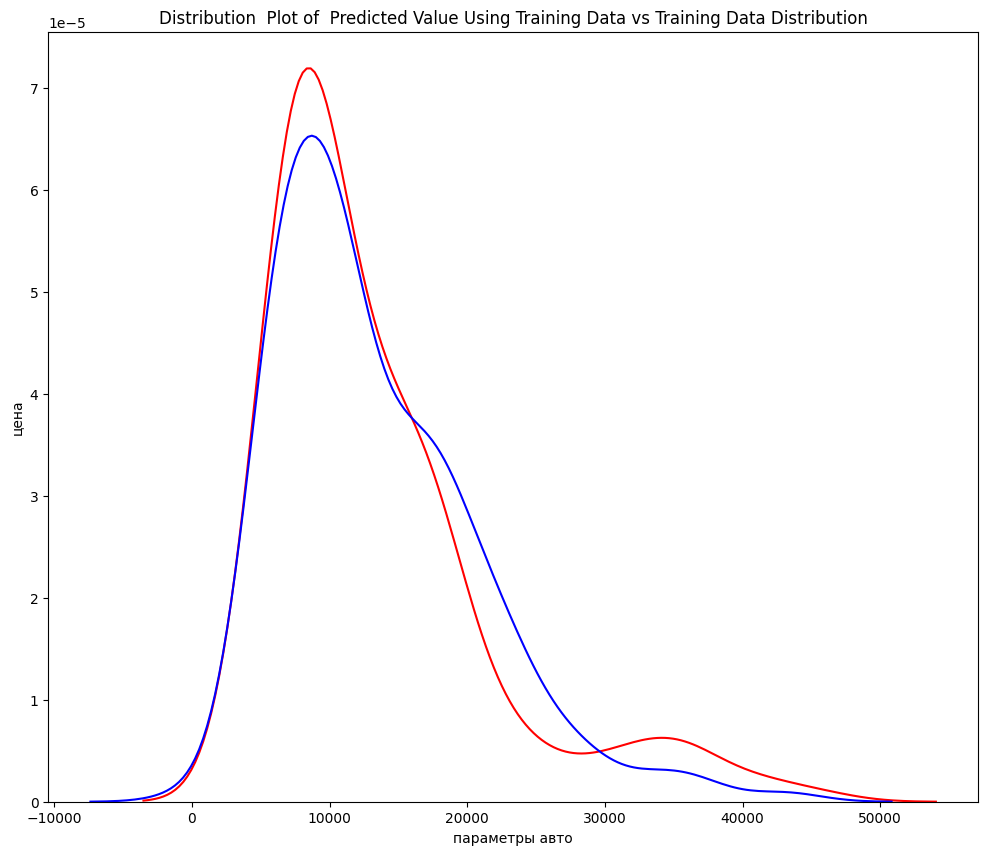

In [358]:
# наша функция принимает наименование таблицы с переменной Title. положим туда наш заголовок
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
# применим функцию графика распределения, наименования осей введем с консоли (по дефолту будут внесенные вручную данные)
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

Рисунок 1: График прогнозируемых значений с использованием учебных данных по сравнению с фактическими значениями учебных данных.


До сих пор модель, кажется, преуспевает в обучении наборе данных обучения.Но что происходит, когда модель встречается с новыми данными из набора данных тестирования?Когда модель генерирует новые значения из тестовых данных, мы видим, что распределение прогнозируемых значений сильно отличается от фактических целевых значений.


C:\Users\admin\AppData\Local\Temp/ipykernel_13208/2544454536.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\admin\AppData\Local\Temp/ipykernel_13208/2544454536.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = 

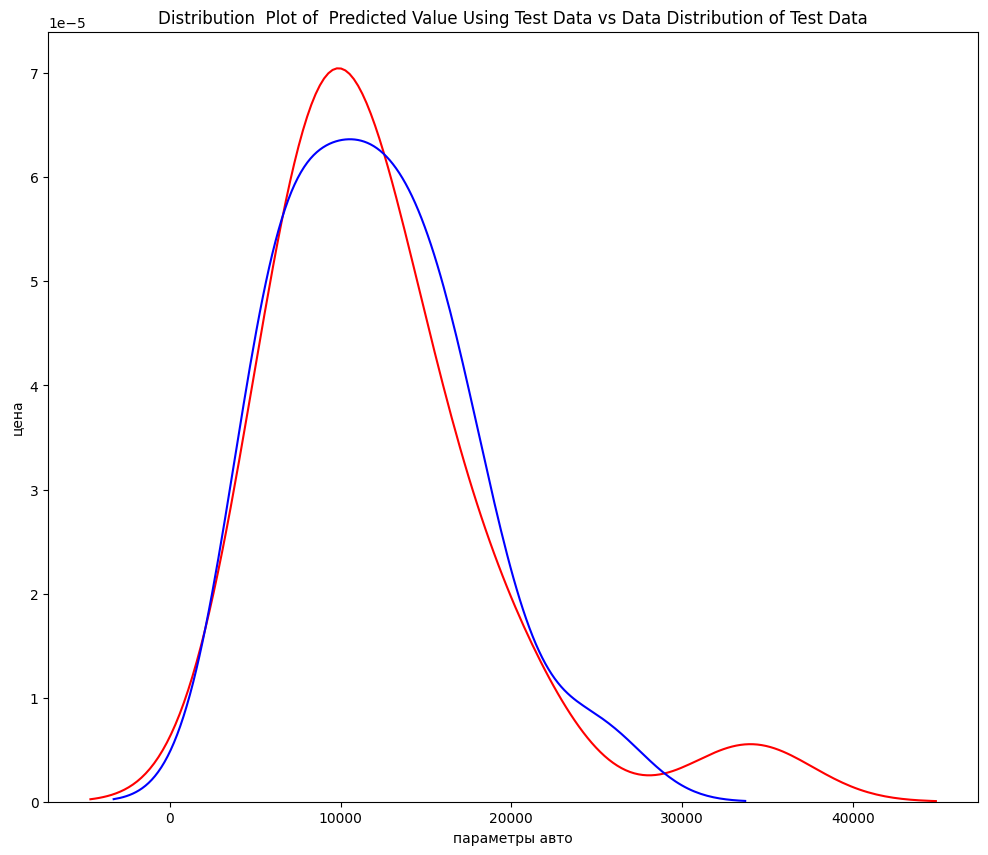

In [357]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Рисунок 2: График прогнозируемого значения с использованием тестовых данных по сравнению со фактическими значениями тестовых данных.


<p> Сравнивая рисунок 1 и рисунок 2, очевидно, что распределение тестовых данных на рисунке 1 гораздо лучше приспосабливается к данным.Эта разница на рисунке 2 видно в диапазоне от 5000 до 15 000.Именно здесь форма распределения чрезвычайно отличается.Давайте посмотрим, если полиномиальная регрессия также демонстрирует падение точности прогнозирования при анализе тестового набора данных. </P>


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

<h4> ПЕРЕОБУЧЕНИЕ</h4>

при тестировании вашей модели с использованием тестового набора ваша модель может работать плохо, поскольку она моделирует шум, а не основной процесс, который генерировал отношения.

Давайте создадим полиномиальную модель степени 5. </P>

Давайте использовать 55 процентов данных для обучения, а остальное для тестирования (0.45):


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

Мы выполним полиномиальное преобразование степени 5 на функции<b>'horsepower'</b>. 


In [ ]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5)

Теперь давайте создадим модель линейной регрессии «Poly» и обучите ее.


In [ ]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression()

Мы можем увидеть выходной сигнал нашей модели, используя метод «прогноз».Мы присваиваем значения «yhat».


In [ ]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6728.65566037,  7307.9878638 , 12213.7877412 , 18893.24796457,
       19995.95185894])

Давайте возьмем первые пять прогнозируемых значений и сравним их с фактическими целями.


In [ ]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.65566037  7307.9878638  12213.7877412  18893.24796457]
True values: [ 6295. 10698. 13860. 13499.]


Мы будем использовать функцию «Pollyplot», которую мы определили в начале лаборатории для отображения учебных данных, тестирования данных и прогнозируемой функции.


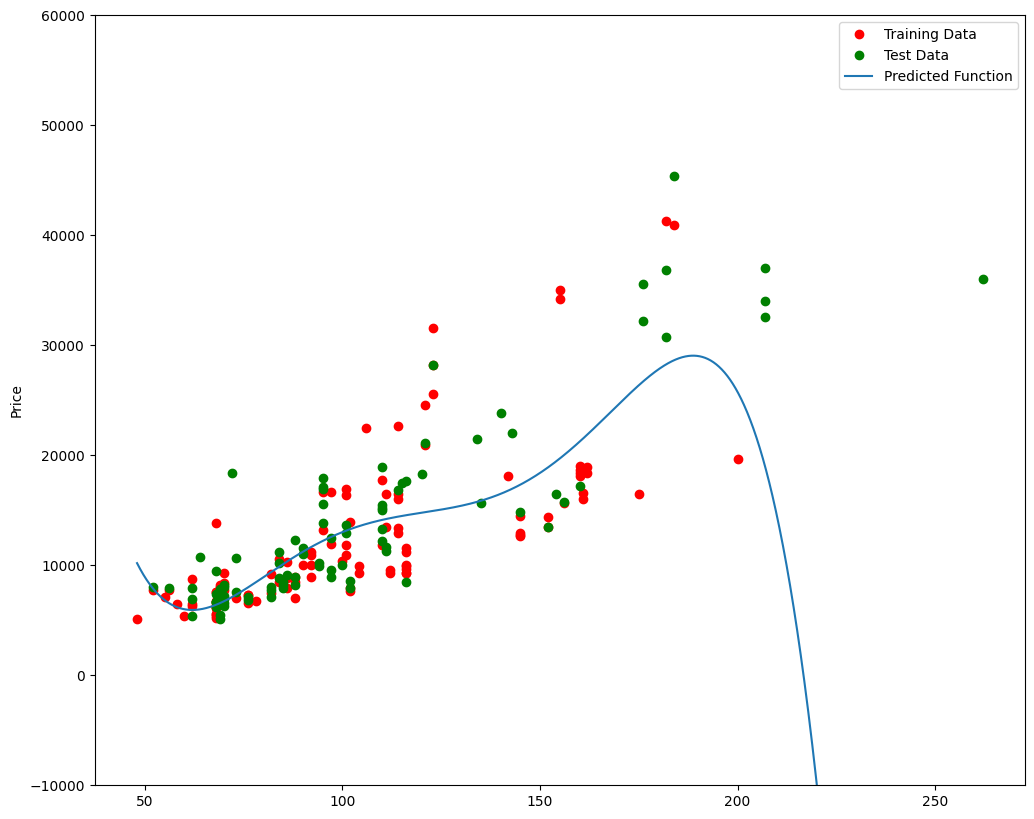

In [ ]:
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)

Рисунок 3: Модель полиномиальной регрессии, в которой красные точки представляют собой обучающие данные, зеленые точки представляют данные тестирования, а синяя линия представляет прогноз модели. 


Мы видим, что оценочная функция, по -видимому, отслеживает данные, но около 200 лошадиных сил, функция начинает расходиться с точек данных.

 R^2 для тренировочныхз данных:


In [ ]:
poly.score(x_train_pr, y_train)

0.5567716902121724

R^2 данных тестирования:


In [ ]:
poly.score(x_test_pr, y_test)

-29.87134054062532

Мы видим, что R^2 для данных обучения составляет 0,5567, в то время как r^2 на тестовых данных составляло -29,87.Чем ниже r^2, тем хуже модель.Отрицательный r^2 является признаком переживания.


Давайте посмотрим, как изменяется R^2 на тестовых данных для полиномов различных порядков, а затем постройте результаты:


Text(3, 0.75, 'Maximum R^2 ')

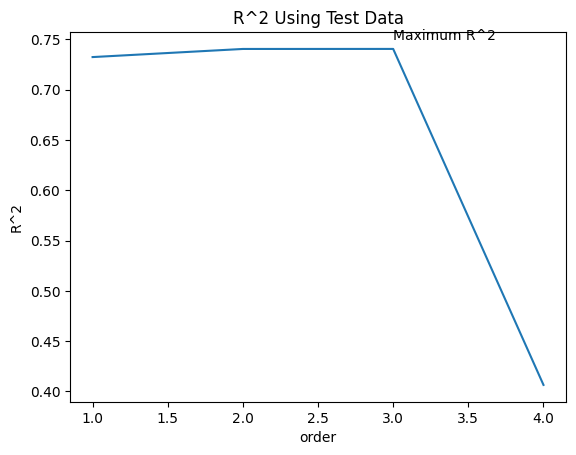

In [ ]:
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    

Мы видим, что R^2 постепенно увеличивается до тех пор, пока не будет использован заказ три полинома.Затем R^2 резко уменьшается в порядке четырех полинома.


Следующая функция будет использоваться в следующем разделе.Пожалуйста, запустите ячейку ниже.


In [ ]:
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

Следующий интерфейс позволяет экспериментировать с различными полиномиальными порядками и различными количествами данных.


In [ ]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f(order, test_data)>

<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 4а): </h1>

<b> мы можем выполнить полиномиальные преобразования с более чем одной функцией.Создать объект «полиномиальные качества» PR1 »второй степени. </B>
</div>

In [ ]:
pr1=PolynomialFeatures(degree=2) 


<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 4b): </h1>

<b>
 Преобразовать образцы обучения и тестирования для функций «Мощность», «бордюр», «Размер двигателя» и «расход топлива Шоссе».Подсказка: используйте метод "fit_transform". </B>
</div>


In [ ]:
x_train_pr1=pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1=pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])


<!-- The answer is below:

x_train_pr1=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
x_test_pr1=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

-->


<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 4c): </h1>
<b>
Сколько измерений у новой функции?Подсказка: используйте атрибут «форма».
</b>
</div>


In [ ]:
x_train_pr1.shape


(110, 15)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Вопрос № 4d): </h1>

<b>
Создайте модель линейной регрессии «Poly1».Обучите объект, используя метод «Fit», используя полиномиальные функции. </B>
</div>


In [ ]:
poly1=LinearRegression().fit(x_train_pr1,y_train)


<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 4e): </h1>
<b> Используйте метод «прогнозировать» для прогнозирования вывода на полиномиальных функциях, а затем используйте функцию «Distribution Plot» для отображения распределения прогнозируемого тестового выхода в зависимости от фактических тестовых данных. </b>
</div>


C:\Users\admin\AppData\Local\Temp/ipykernel_13208/483544288.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\admin\AppData\Local\Temp/ipykernel_13208/483544288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.

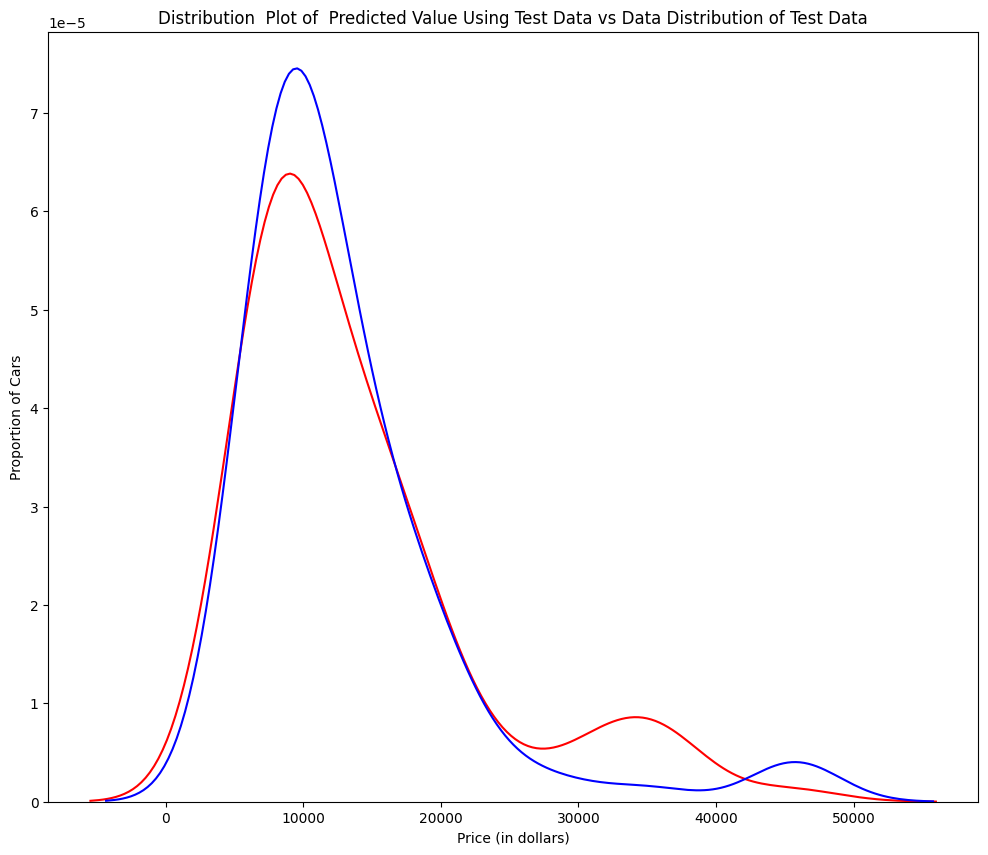

In [ ]:
yhat_test1=poly1.predict(x_test_pr1)

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)


<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 4f): </h1>

<b> Используя график распределения выше, опишите (в словах) две области, где прогнозируемые цены менее точны, чем фактические цены. </b>
</div>

In [ ]:

#The predicted value is higher than actual value for cars where the price $10,000 range, conversely the predicted price is lower than the price cost in the $30,000 to $40,000 range. As such the model is not as accurate in these ranges.

<h2 id="ref3">Часть 3: Ridge Regression. Гребнивая регрессия</h2> 


В этом разделе мы рассмотрим регрессию хребта и посмотрим, как параметр альфа меняет модель.Просто примечание, здесь наши тестовые данные будут использоваться в качестве данных проверки.


Давайте выполним степень два полиномиальных преобразования наших данных.


In [ ]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

Давайте импортируем <b> ridge </b> из модуля <b> линейных моделей </b>.


In [ ]:
from sklearn.linear_model import Ridge

Давайте создадим объект регрессии гребня, установив параметр регуляризации (альфа) на 0,1


In [ ]:
RigeModel=Ridge(alpha=1)

Как и обычная регрессия, вы можете соответствовать модели, используя метод <b> fit </b>.


In [ ]:
RigeModel.fit(x_train_pr, y_train)

Ridge(alpha=1)

Точно так же вы можете получить прогноз: 


In [ ]:
yhat = RigeModel.predict(x_test_pr)

Давайте сравним первые пять прогнозируемых образцов с нашим тестовым набором:


In [ ]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6570.82441941  9636.24891471 20949.92322737 19403.60313256]
test set : [ 6295. 10698. 13860. 13499.]


Мы выбираем значение альфа, которое минимизирует ошибку теста.Для этого мы можем использовать для петли.Мы также создали планку прогресса, чтобы увидеть, сколько итераций мы завершили до сих пор.


In [ ]:
from tqdm import tqdm

Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

  0%|          | 0/1000 [00:00<?, ?it/s, Test Score=0.541, Train Score=0.863]

100%|██████████| 1000/1000 [00:02<00:00, 366.84it/s, Test Score=0.564, Train Score=0.859]


Мы можем построить значение r^2 для разных альфа:


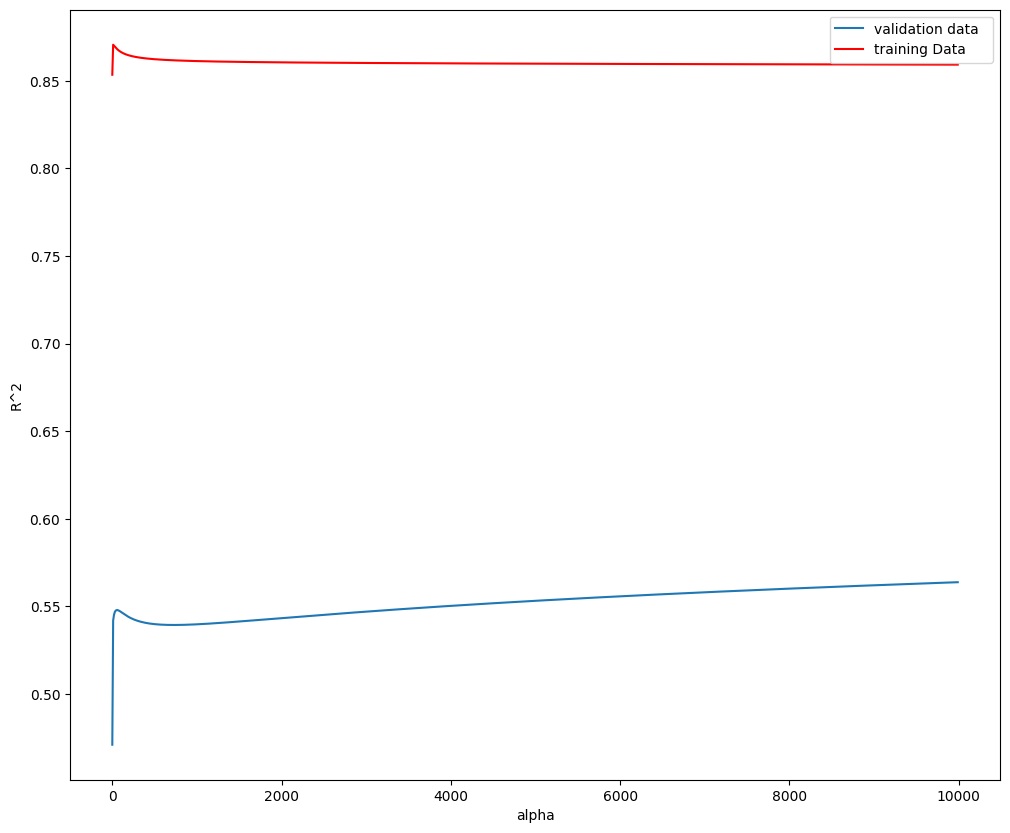

In [ ]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

** Рисунок 4 **: Синяя линия представляет r^2 данных проверки, а красная линия представляет r^2 учебных данных.Ось X представляет различные значения альфа.


Здесь модель создана и протестирована на одних и тех же данных, поэтому данные обучения и тестирования одинаковы.

Красная линия на рисунке 4 представляет r^2 учебных данных.Как альфа увеличивает, R^2 уменьшается.Следовательно, по мере увеличения альфа модель хуже при учебных данных

Синяя линия представляет r^2 в данных проверки.По мере увеличения значения для альфа R^2 увеличивается и сходится в точке.

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Вопрос #5): </h1>
Выполнить регрессию хребта.Рассчитайте R^2, используя полиномиальные функции, используйте учебные данные для обучения модели и используйте тестовые данные для проверки модели.Альфа -параметр должен быть установлен на 10.
</div>


In [ ]:
RigeModel = Ridge(alpha=10) 
RigeModel.fit(x_train_pr, y_train)
RigeModel.score(x_test_pr, y_test)


0.5418576440206506

<h2 id="ref4">Часть 4: Grid Search</h2>


Термин Альфа - это гиперпараметр.У Sklearn есть класс <b> gridsearchcv </b>, чтобы упростить процесс поиска лучшего гиперпараметра.


Давайте импортируем <b> gridsearchcv </b> из модуля <b> model_selection </b>.


In [ ]:
from sklearn.model_selection import GridSearchCV

Мы создаем словарь значений параметров:


In [ ]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

Создайте объект регрессии гребня


In [ ]:
RR=Ridge()
RR

Ridge()

Создайте объект поиска :


In [ ]:
Grid1 = GridSearchCV(RR, parameters1,cv=4)

Чтобы избежать предупреждения об ископке из -за параметра IID, мы установили значение IID на «нет».

Установите модель:

In [ ]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

Объект находит наилучшие значения параметров в данных проверки.Мы можем получить оценку с лучшими параметрами и назначить его переменной BestRR следующим образом:


In [ ]:
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000)

Теперь мы проверяем нашу модель на тестовых данных:


In [ ]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.8411649831036152

<div class = "оповещение о том, что AlertDanger" Style = "Margin-Top: 20px">
<h1> Вопрос № 6): </h1>
Выполните поиск сетки параметра альфа и параметр нормализации, затем найдите наилучшие значения параметров:
</div>


In [ ]:

parameters2= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000]}]
Grid2 = GridSearchCV(Ridge(), parameters2, cv=4)
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
Grid2.best_estimator_



Ridge(alpha=10000)